In [1]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("SMSSpamCollection", delimiter = '\t')

In [10]:
df = df.iloc[:, [1, 0]]
df.columns = ["Data", "Label"]

df.head()

,Data,Label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [11]:
df.to_csv("Dataset.csv", index = False)

In [12]:
df = pd.read_csv("Dataset.csv")
df

,Data,Label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will ü b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [13]:
import re

def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text

df["Data"] = df["Data"].apply(clean_text)
df.head()

,Data,Label
0,go until jurong point crazy available only in ...,ham
1,ok lar joking wif u oni,ham
2,free entry in 2 a wkly comp to win fa cup fina...,spam
3,u dun say so early hor u c already then say,ham
4,nah i don t think he goes to usf he lives arou...,ham


In [14]:
df["Label"] = df["Label"].map({'spam': 1, 'ham': 0})
df.head()

,Data,Label
0,go until jurong point crazy available only in ...,0
1,ok lar joking wif u oni,0
2,free entry in 2 a wkly comp to win fa cup fina...,1
3,u dun say so early hor u c already then say,0
4,nah i don t think he goes to usf he lives arou...,0


In [26]:
df['Label'].value_counts()

,count
Label,
0,4825
1,747


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

tfidf = TfidfVectorizer(max_features = 5000)
x_tfidf = tfidf.fit_transform(df["Data"])

smote = SMOTE(random_state = 42)
x_upsample, y_upsample = smote.fit_resample(x_tfidf, df['Label'])

df_upsampled = pd.DataFrame(x_upsample.toarray(), columns = tfidf.get_feature_names_out())
df_upsampled['Label'] = y_upsample

df_upsampled.head()

,00,000,008704050406,01223585334,02,0207,02073162414,021,03,04,...,zeros,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [29]:
df_upsampled['Label'].value_counts()

,count
Label,
0,4825
1,4825


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

x = df_upsampled.drop('Label', axis = 1)
y = df_upsampled['Label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

nb = MultinomialNB()
nb.fit(x_train, y_train)

y_pred = nb.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.9823834196891191
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       990
           1       0.99      0.98      0.98       940

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930



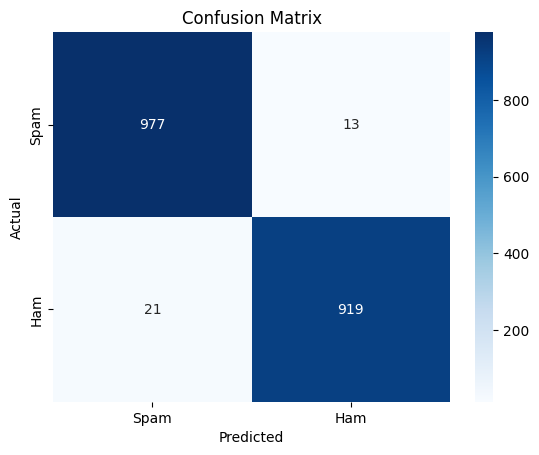

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels = ['Spam', 'Ham'], yticklabels = ['Spam', 'Ham'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
import joblib

joblib.dump(nb, 'spam_model.pkl')
joblib.dump(tfidf, 'spam_tfidf.pkl')

['spam_tfidf.pkl']

In [37]:
model = joblib.load('spam_model.pkl')
tfidf = joblib.load('spam_tfidf.pkl')

test_emails = [
    "Congratulations! You've won a $1000 Amazon gift card. Click here to claim your prize: [fake-link.com].",
    "Hi John, Just checking in to see how the project is going. Let me know if you need any assistance.",
    "Urgent! Your bank account has been compromised. Please log in immediately to secure your account: [phishing-link.com].",
    "Your subscription to the newsletter has been successfully renewed. Thank you for being a valued customer!"
]

test_emails_tfidf = tfidf.transform(test_emails)
predictions = model.predict(test_emails_tfidf)

for email, label in zip(test_emails, predictions):
    print(f"Email: {email}\n Predicted Label: {'Spam' if label == 1 else 'Ham'}\n" )


Email: Congratulations! You've won a $1000 Amazon gift card. Click here to claim your prize: [fake-link.com].
 Predicted Label: Spam

Email: Hi John, Just checking in to see how the project is going. Let me know if you need any assistance.
 Predicted Label: Ham

Email: Urgent! Your bank account has been compromised. Please log in immediately to secure your account: [phishing-link.com].
 Predicted Label: Spam

Email: Your subscription to the newsletter has been successfully renewed. Thank you for being a valued customer!
 Predicted Label: Spam

